Carlos Bravo Garrán - 100474964

# __Seed Clustering__

In [1]:

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from matplotlib import style
import matplotlib.cm as cm
style.use('ggplot') or plt.style.use('ggplot')

from sklearn.preprocessing import MinMaxScaler, RobustScaler, StandardScaler
from sklearn.decomposition import PCA
from sklearn.pipeline import make_pipeline
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.metrics import silhouette_samples
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram
from sklearn.cluster import DBSCAN
from sklearn.neighbors import NearestNeighbors

import seaborn as sns

import warnings
warnings.filterwarnings('ignore')

### __1. Load the dataset__

Load the seed dataset from a CSV file. 

The features are stored in `X`, and the target class labels are stored in `y`.

Add seed variable for random states (`100474964`)


In [2]:
data = pd.read_csv('data/semillas.csv')
X = data.drop(columns=['clase'])
y = data['clase']

seed = 100474964

print(data.head())

    area  perimetro  compacidad  longitud  anchura  asimetria  surco  clase
0  15.26      14.84      0.8710     5.763    3.312      2.221  5.220      1
1  14.88      14.57      0.8811     5.554    3.333      1.018  4.956      1
2  14.29      14.09      0.9050     5.291    3.337      2.699  4.825      1
3  13.84      13.94      0.8955     5.324    3.379      2.259  4.805      1
4  16.14      14.99      0.9034     5.658    3.562      1.355  5.175      1


### __2. Comparison of Scalers__

This section identifies the most appropriate scaler for the seed dataset before applying clustering algorithms. Scaling ensures that all features contribute equally to the distance calculations.

Three scalers are compared:
- MinMaxScaler
- RobustScaler
- StandardScaler

The scaled data is projected into 2D using PCA for visual evaluation.

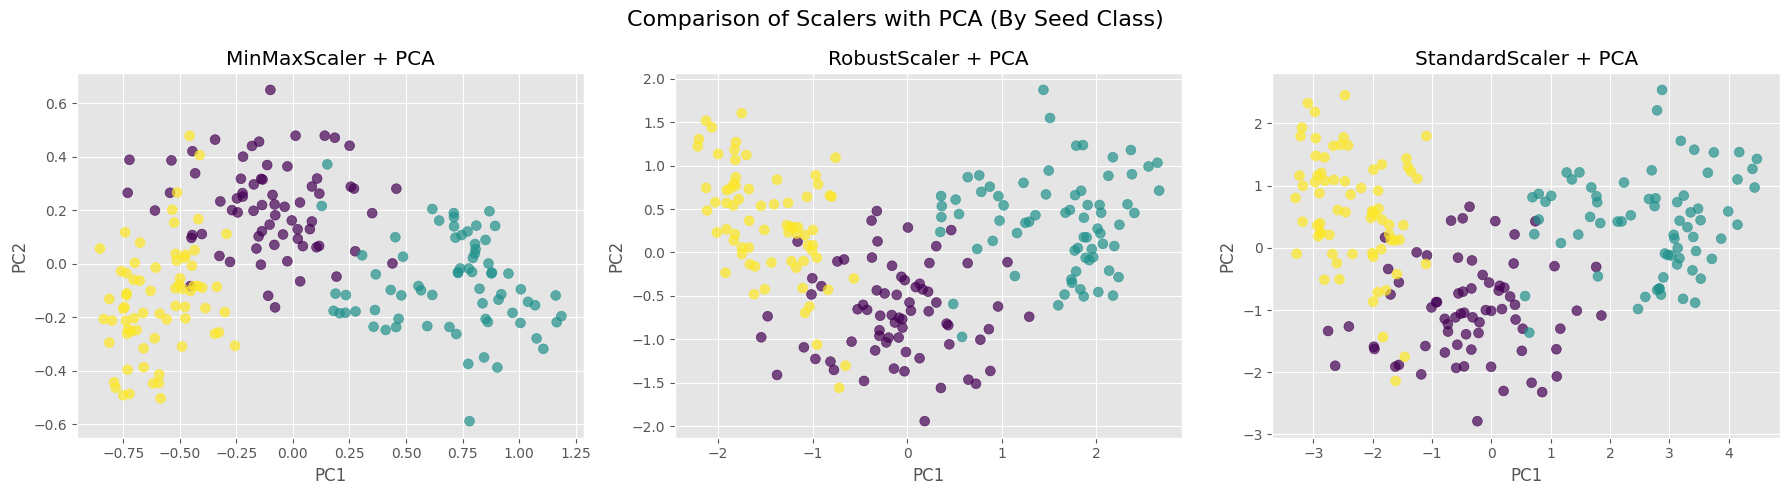

In [3]:
scalers = {
    'MinMaxScaler': MinMaxScaler(),
    'RobustScaler': RobustScaler(),
    'StandardScaler': StandardScaler()
}

plt.figure(figsize=(18, 5))

for i, (name, scaler) in enumerate(scalers.items(), 1):
    pipeline = make_pipeline(scaler, PCA(n_components=2, random_state=seed))
    
    X_pca = pipeline.fit_transform(X)
    
    plt.subplot(1, 3, i)
    scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y, cmap='viridis', alpha=0.7, s=50)
    plt.title(f'{name} + PCA')
    plt.xlabel('PC1')
    plt.ylabel('PC2')
    plt.grid(True)

plt.suptitle('Comparison of Scalers with PCA (By Seed Class)', fontsize=16)
plt.tight_layout()
plt.show()


#### 2.1 Best Scaler Selection

After observing the PCA plots:

- **MinMaxScaler**: The data points are well distributed with moderate separation between different seed classes. Although some overlap exists, the distribution appears balanced and suitable for clustering.
- **RobustScaler**: There is a good separation of classes, but the spread of the data is larger, which may not be ideal for density-based methods.
- **StandardScaler**: While resistant to outliers, the classes are not well separated, making clustering more difficult.

The scaler selected is **MinMaxScaler** because it provides a balanced and homogeneous distribution of the data, facilitating the identification of clusters without introducing large variations in scale.


#### 2.2 Variance Explained by PCA

To ensure that the 2D projection using PCA retains enough information from the original dataset, calculate, after applying each scaler, the variance explained by the two principal components and the total variance.


In [4]:
variance_ratios = {}

for name, scaler in scalers.items():
    X_scaled = scaler.fit_transform(X)
    pca = PCA(n_components=2, random_state=seed)
    X_pca = pca.fit_transform(X_scaled)
    
    variance_explained = np.sum(pca.explained_variance_ratio_)
    variance_ratios[name] = {
        'PC1': pca.explained_variance_ratio_[0],
        'PC2': pca.explained_variance_ratio_[1],
        'Total': variance_explained
    }

variance_table = pd.DataFrame.from_dict(variance_ratios, orient='index')
variance_table.index.name = 'Scaler'
variance_table.reset_index(inplace=True)

display(variance_table)


,Scaler,PC1,PC2,Total
0,MinMaxScaler,0.789034,0.129095,0.918129
1,RobustScaler,0.669457,0.199626,0.869084
2,StandardScaler,0.718743,0.171082,0.889825


The results show that all three scalers achieve a high variance explanation (>85%), indicating that the 2D PCA projection is representative of the original dataset in every case.

Among them, **MinMaxScaler** achieves the highest variance explained, with 91.81%.

It's confirmed that using **MinMaxScaler** is appropriate, as it retains the largest proportion of the original data variance after dimensionality reduction. Therefore, MinMaxScaler is selected for the clustering tasks.

#### 2.3 Scaling and PCA
The dataset was scaled using the selecter scaler (**MinMaxScaler**) and reduced to two dimensions using PCA

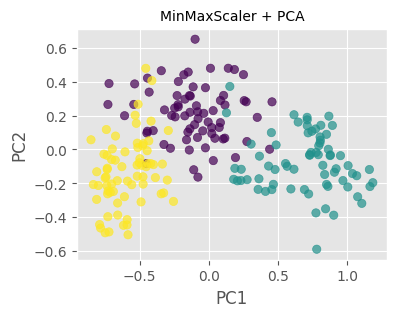

In [5]:
pipeline = make_pipeline(
    MinMaxScaler(),
    PCA(n_components=2, random_state=seed)
)

X_final_pca = pipeline.fit_transform(X)

plt.figure(figsize=(4, 3))
plt.scatter(X_final_pca[:, 0], X_final_pca[:, 1], c=y, cmap='viridis', alpha=0.7)
plt.title('MinMaxScaler + PCA (Final Preprocessing)')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('MinMaxScaler + PCA', fontsize=10)
plt.grid(True)
plt.show()


### __3. Clustering__

Apply unsupervised clustering techniques on the PCA-transformed seed dataset to identify natural groupings:

- K-Means
- Hierarchical Clustering
- DBSCAN

For each method,the key hyperparameters are tuned, the results visualized and their performance compared to determine which best captures the structure of the data.


#### __3.1 K-means clustering__

Based on the visual inspection of the PCA plot, k = 3 is initially selected as a reasonable number of clusters.

##### __Model creation and training__

In [6]:
modelo_kmeans = KMeans(
    n_clusters=3,
    n_init=25,
    random_state=seed
)

modelo_kmeans.fit(X_final_pca)


KMeans(n_clusters=3, n_init=25, random_state=100474964)

##### __Cluster prediction__

In [7]:
y_pred = modelo_kmeans.predict(X_final_pca)


##### __Cluster Visualization and Evaluation__


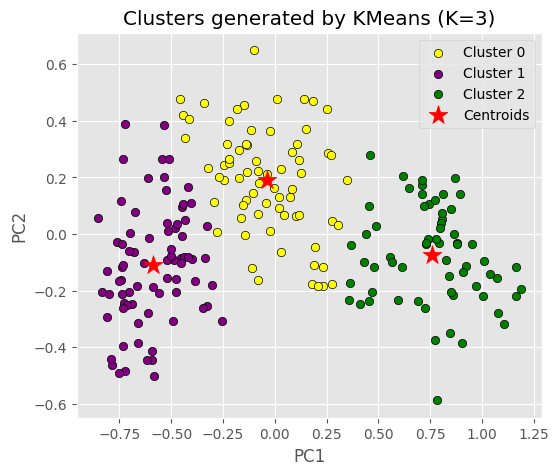

In [8]:
colors = ['yellow', 'purple', 'green', 'orange', 'purple']

fig, ax = plt.subplots(1, 1, figsize=(6, 5))

for cluster in np.unique(y_pred):
    ax.scatter(
        x = X_final_pca[y_pred == cluster, 0],
        y = X_final_pca[y_pred == cluster, 1],
        color = colors[cluster],
        label = f"Cluster {cluster}",
        edgecolor = 'black',
        marker = 'o'
    )

ax.scatter(
    x = modelo_kmeans.cluster_centers_[:, 0],
    y = modelo_kmeans.cluster_centers_[:, 1],
    c = 'red',
    s = 200,
    marker = '*',
    label = 'Centroids'
)

ax.set_title('Clusters generated by KMeans (K=3)')
ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.legend()
ax.grid(True)
plt.show()


The K-Means clustering with k = 3 produced three clearly defined groups in the PCA-transformed space.

- Each cluster is compact and well-separated from the others, with minimal overlap between groups.
- The centroids are located close to the center of each cluster, indicating that the algorithm has correctly captured the dense regions of the data.
- The overall structure suggests that the data naturally forms three main groups, supporting the choice of k = 3.
- Although the clusters are not perfectly spherical, the distribution around each centroid is balanced and coherent.

In conclusion, the visual inspection confirms that K-Means with k = 3 is a good fit for the structure observed in the seed dataset.

Even so, other values of k will be tested to ensure robustness.

#### __Evaluation of K-Means with Different Values of k__

In this section, the performance of the K-Means algorithm is evaluated using different values of k (number of clusters). This helps identify the optimal number of clusters that best represents the structure of the data.

Plots are generated for k = 2 and k = 4, comparing the distribution of data in the PCA space.


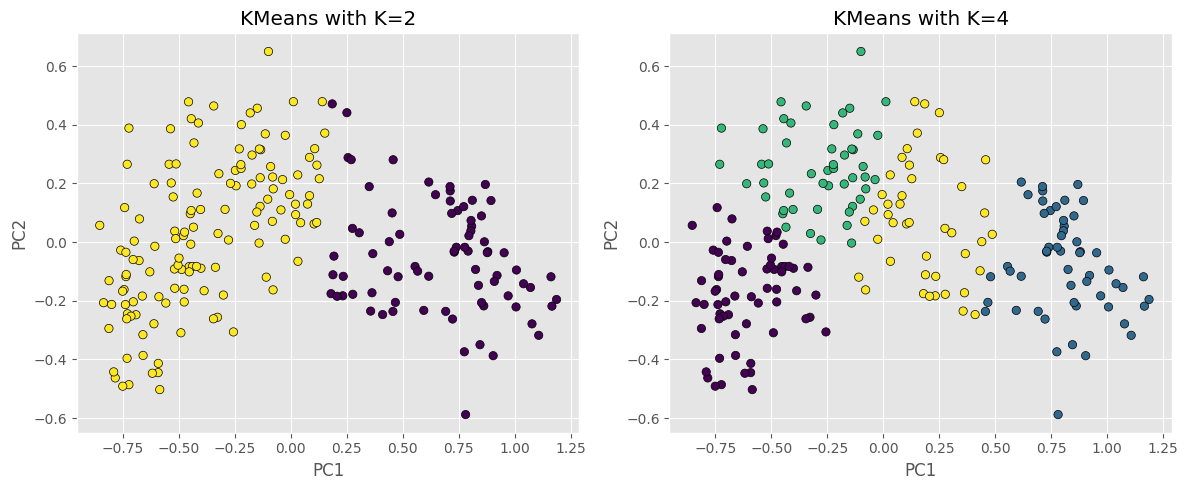

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Results for K = 2
y_predict_2 = KMeans(n_clusters=2, n_init=25, random_state=seed).fit_predict(X=X_final_pca)
ax[0].scatter(
    x = X_final_pca[:, 0],
    y = X_final_pca[:, 1],
    c = y_predict_2,
    marker = 'o',
    edgecolor = 'black'
)
ax[0].set_title('KMeans with K=2')
ax[0].set_xlabel('PC1')
ax[0].set_ylabel('PC2')
ax[0].grid(True)

# Results for K = 4
y_predict_4 = KMeans(n_clusters=4, n_init=25, random_state=seed).fit_predict(X=X_final_pca)
ax[1].scatter(
    x = X_final_pca[:, 0],
    y = X_final_pca[:, 1],
    c = y_predict_4,
    marker = 'o',
    edgecolor = 'black'
)
ax[1].set_title('KMeans with K=4')
ax[1].set_xlabel('PC1')
ax[1].set_ylabel('PC2')
ax[1].grid(True)

plt.tight_layout()
plt.show()



- With **k = 2**, the data is divided into two large groups, losing important internal structures.
- With **k = 4**, the clustering tends to oversegment the data, creating small clusters that do not correspond to natural groupings.
- With **k = 3**, the data is divided into three compact and well-separated groups, without significant overlap or oversegmentation.

The visual comparison confirms that **k = 3** is the most appropriate number of clusters for this dataset.

##### __Elbow Method__

To support the selection of the number of clusters, the elbow method is applied, which analyzes how the inertia decreases as the number of clusters increases.

The optimal number of clusters is identified at the point where adding an additional cluster no longer significantly reduces the inertia.

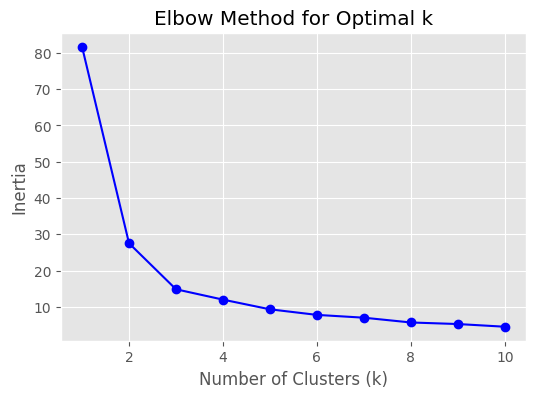

In [10]:
inertia = []
K = range(1, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(X_final_pca)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(6, 4))
plt.plot(K, inertia, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')
plt.grid(True)
plt.show()


The plot of inertia facing the number of clusters shows a clear "elbow" at k = 3, reconfirming that k = 3 is the most appropriate number of clusters for this dataset.

##### __Silhouette Method__

The silhouette coefficient measures how similar points within the same cluster are compared to those in other clusters. The closer to 1, the better defined the cluster.

We will calculate and visualize the average silhouette coefficient for different values of k (from 2 to 10):

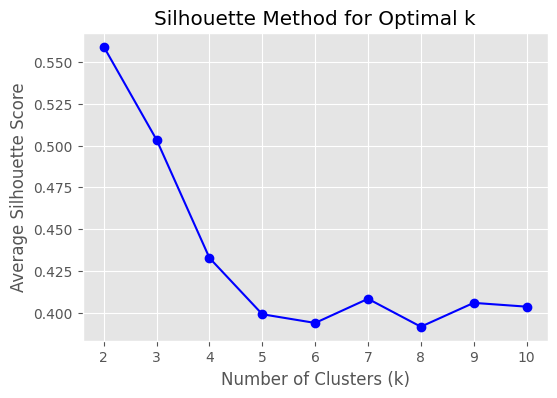

In [11]:
silhouette_scores = []
K = range(2, 11)

for k in K:
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=seed)
    labels = kmeans.fit_predict(X_final_pca)
    score = silhouette_score(X_final_pca, labels)
    silhouette_scores.append(score)

plt.figure(figsize=(6, 4))
plt.plot(K, silhouette_scores, 'bo-')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Average Silhouette Score')
plt.title('Silhouette Method for Optimal k')
plt.grid(True)
plt.show()


It can be observed that k = 2 has the highest silhouette coefficient (~0.56), suggesting good separation between two groups. However, this may be because the classes are divided into two large generic groups, ignoring more natural subdivisions.

This differs from the choice we made earlier of k = 3, so to clarify, we will generate individual silhouette plots for k = 2 to k = 5 to see if the clusters are well-defined and how consistent the assignments are.

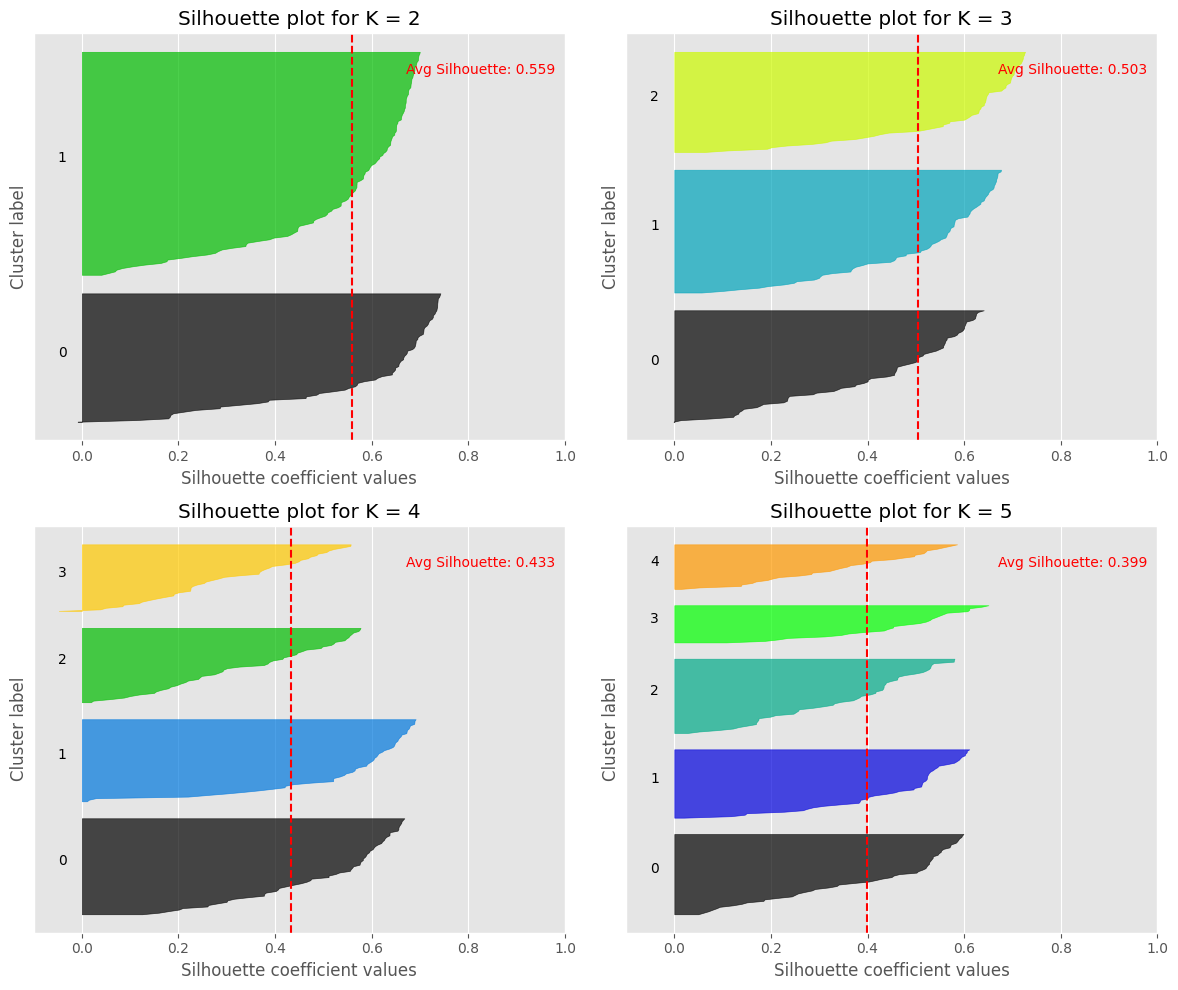

In [12]:
Ks = [2, 3, 4, 5]
fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for idx, k in enumerate(Ks):
    ax = axes[idx]
    kmeans = KMeans(n_clusters=k, n_init=25, random_state=seed)
    cluster_labels = kmeans.fit_predict(X_final_pca)

    silhouette_vals = silhouette_samples(X_final_pca, cluster_labels)

    y_lower = 10
    for i in range(k):
        ith_cluster_silhouette_vals = silhouette_vals[cluster_labels == i]
        ith_cluster_silhouette_vals.sort()

        size_cluster_i = ith_cluster_silhouette_vals.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax.fill_betweenx(
            np.arange(y_lower, y_upper),
            0,
            ith_cluster_silhouette_vals,
            facecolor=color,
            edgecolor=color,
            alpha=0.7
        )

        ax.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
        y_lower = y_upper + 10 

    avg_score = silhouette_score(X_final_pca, cluster_labels)
    ax.text(0.7, 0.9, f'Avg Silhouette: {avg_score:.3f}', transform=ax.transAxes, color="red", fontsize=10)


    ax.axvline(x=avg_score, color="red", linestyle="--")
    ax.set_title(f'Silhouette plot for K = {k}')
    ax.set_xlabel('Silhouette coefficient values')
    ax.set_ylabel('Cluster label')
    ax.set_yticks([])
    ax.set_xlim([-0.1, 1])
    ax.grid(True)

plt.tight_layout()
plt.show()


| Number of Clusters (k) | Average Silhouette | Analysis                                                                 |
|------------------------|--------------------|-------------------------------------------------------------------------------|
| 2                      | ~0.56           | Clear and compact structure, but may be an excessive simplification          |
| 3                      | ~0.51           | Good separation, consistent with the actual number of classes (3)            |
| 4                      | ~0.43           | Overclustering, appearance of small clusters and overlap between groups      |
| 5                      | ~0.40           | Worse cohesion, some artificial clusters and poor point assignment           |


The silhouette plots show that the values of n_clusters = 4 and 5 are a poor choice due to below-average silhouette scores and the appearance of clusters with very unequal sizes.

On the other hand, the silhouette analysis is more ambiguous when comparing k = 2 and k = 3, as we have seen before. The value of k = 2 presents the highest average silhouette coefficient (~0.56), and its clusters are clearly separated, although the grouping may be too general, hiding more detailed structures. This can also be seen in the plot, where one of the clusters (cluster 0) is larger and encompasses multiple subsets.

With k = 3, the average silhouette coefficient is slightly lower (~0.51), but the three clusters exhibit good internal cohesion and relative separation, with more balanced sizes and consistent bars. Additionally, k = 3 is consistent with the results obtained previously.

In summary, although k = 2 achieves the highest average score, the visual and conceptual analysis suggests that k = 3 offers a richer, more interpretable segmentation aligned with the actual structure of the dataset.



#### __3.2 Hierarchical Clustering__

In this section, **hierarchical clustering** (Agglomerative Clustering) is applied to the seed dataset transformed using PCA. Different linkage methods are tested (`linkage`), and the results are analyzed both visually and quantitatively through scatter plots, dendrograms, and the silhouette coefficient.

__Tested Linkage Methods__

The following hierarchical linkage methods are compared:
- **Ward**: Minimizes variance within clusters.
- **Complete**: Maximizes the distance between the farthest points.
- **Average**: Uses the average distance between points.
- **Single**: Considers the minimum distance between points (may form chains).


##### **Comparison of Methods Using Scatter Plots**

Silhouette Score (ward linkage): 0.471
Silhouette Score (complete linkage): 0.348
Silhouette Score (average linkage): 0.475
Silhouette Score (single linkage): -0.111


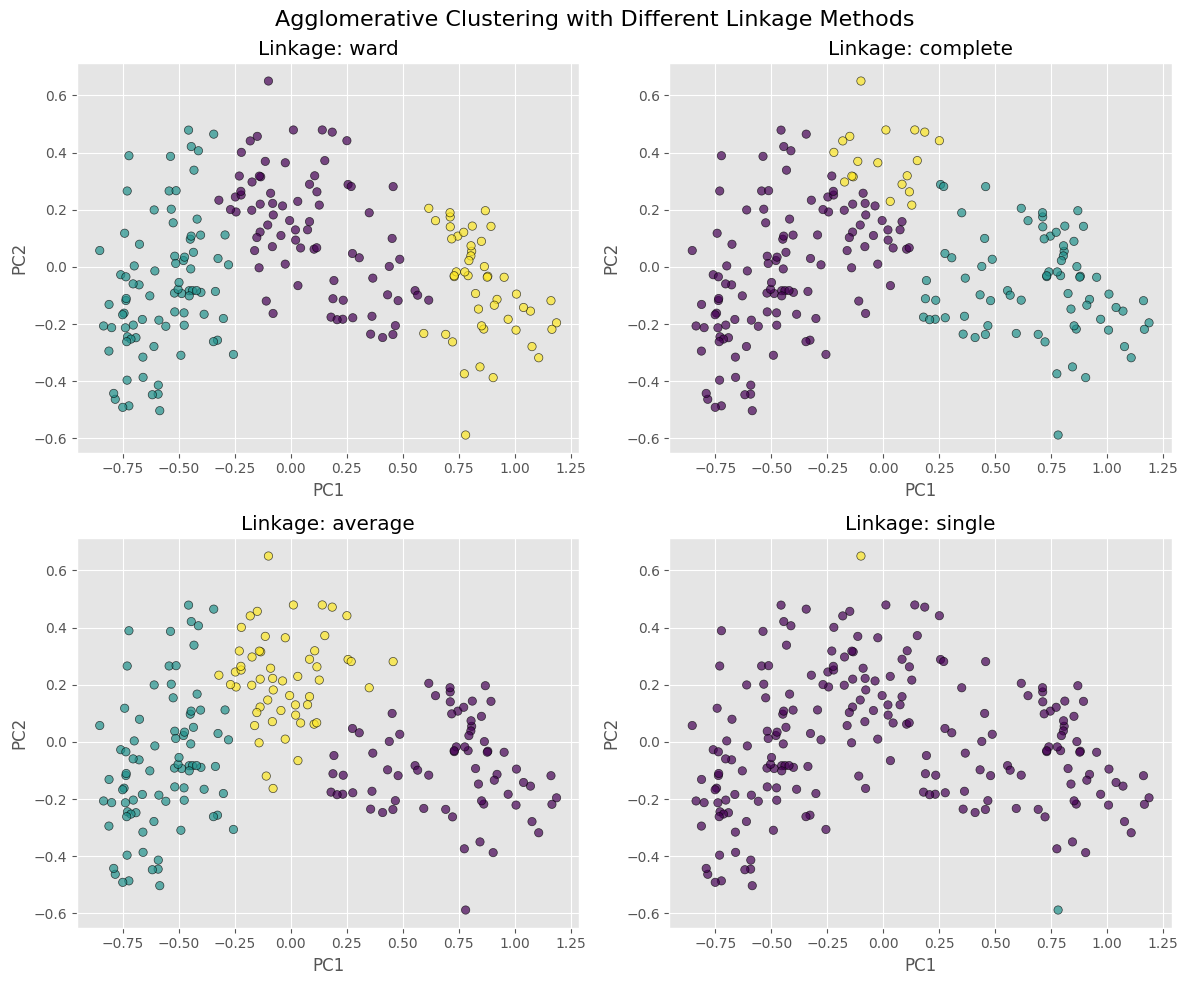

In [13]:
linkage_methods = ['ward', 'complete', 'average', 'single']

fig, axes = plt.subplots(2, 2, figsize=(12, 10))
axes = axes.flatten()

for i, method in enumerate(linkage_methods):
    # Ward sólo admite distancia euclídea
    if method == 'ward':
        model = AgglomerativeClustering(n_clusters=3, linkage=method)
    else:
        model = AgglomerativeClustering(n_clusters=3, linkage=method, metric='euclidean')

    y_pred = model.fit_predict(X_final_pca)
    score = silhouette_score(X_final_pca, y_pred)
    print(f"Silhouette Score ({method} linkage): {score:.3f}")

    axes[i].scatter(X_final_pca[:, 0], X_final_pca[:, 1], c=y_pred, cmap='viridis', edgecolor='k', alpha=0.7)
    axes[i].set_title(f'Linkage: {method}')
    axes[i].set_xlabel('PC1')
    axes[i].set_ylabel('PC2')
    axes[i].grid(True)

plt.suptitle('Agglomerative Clustering with Different Linkage Methods', fontsize=16)
plt.tight_layout()
plt.show()


Los resultados muestran que el método `ward` genera agrupaciones compactas y bien separadas, con una puntuación de silueta ligeramente superior a los demás. Los métodos `average` y `complete` ofrecen buenos resultados, pero con mayor solapamiento. Por otro lado, el método `single` suele ser menos recomendable, ya que tiende a formar cadenas y clusters poco definidos, por lo que este método se descarta directamente.


Function to create a dendrogram from the hierarchical clustering model.


In [14]:
def plot_dendrogram(model, **kwargs):
    counts = np.zeros(model.children_.shape[0])
    n_samples = len(model.labels_)
    for i, merge in enumerate(model.children_):
        current_count = 0
        for child_idx in merge:
            if child_idx < n_samples:
                current_count += 1
            else:
                current_count += counts[child_idx - n_samples]
        counts[i] = current_count

    linkage_matrix = np.column_stack([model.children_, model.distances_,
                                      counts]).astype(float)

    dendrogram(linkage_matrix, **kwargs)

Create hierarchical models with different linkage methods and construct the complete clustering tree without fixing the number of clusters, to generate dendrograms with the full structure of merges.

In [15]:

modelo_hclust_complete = AgglomerativeClustering(
    linkage  = 'complete',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_complete.fit(X=X_final_pca)

modelo_hclust_average = AgglomerativeClustering(
    linkage  = 'average',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_average.fit(X=X_final_pca)

modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    distance_threshold = 0,
    n_clusters         = None
)
modelo_hclust_ward.fit(X=X_final_pca)

AgglomerativeClustering(distance_threshold=0, n_clusters=None)

##### **Visualization of Complete Dendrograms**

Complete dendrograms are generated for the `ward`, `average`, and `complete` methods, based on models trained without fixing the number of clusters (`n_clusters=None`) and with `distance_threshold=0`. These dendrograms display the entire hierarchy of merges between observations, from individual points to the total grouping.

This representation allows for the analysis of the global hierarchical structure and observation of the distances at which the merges occur.


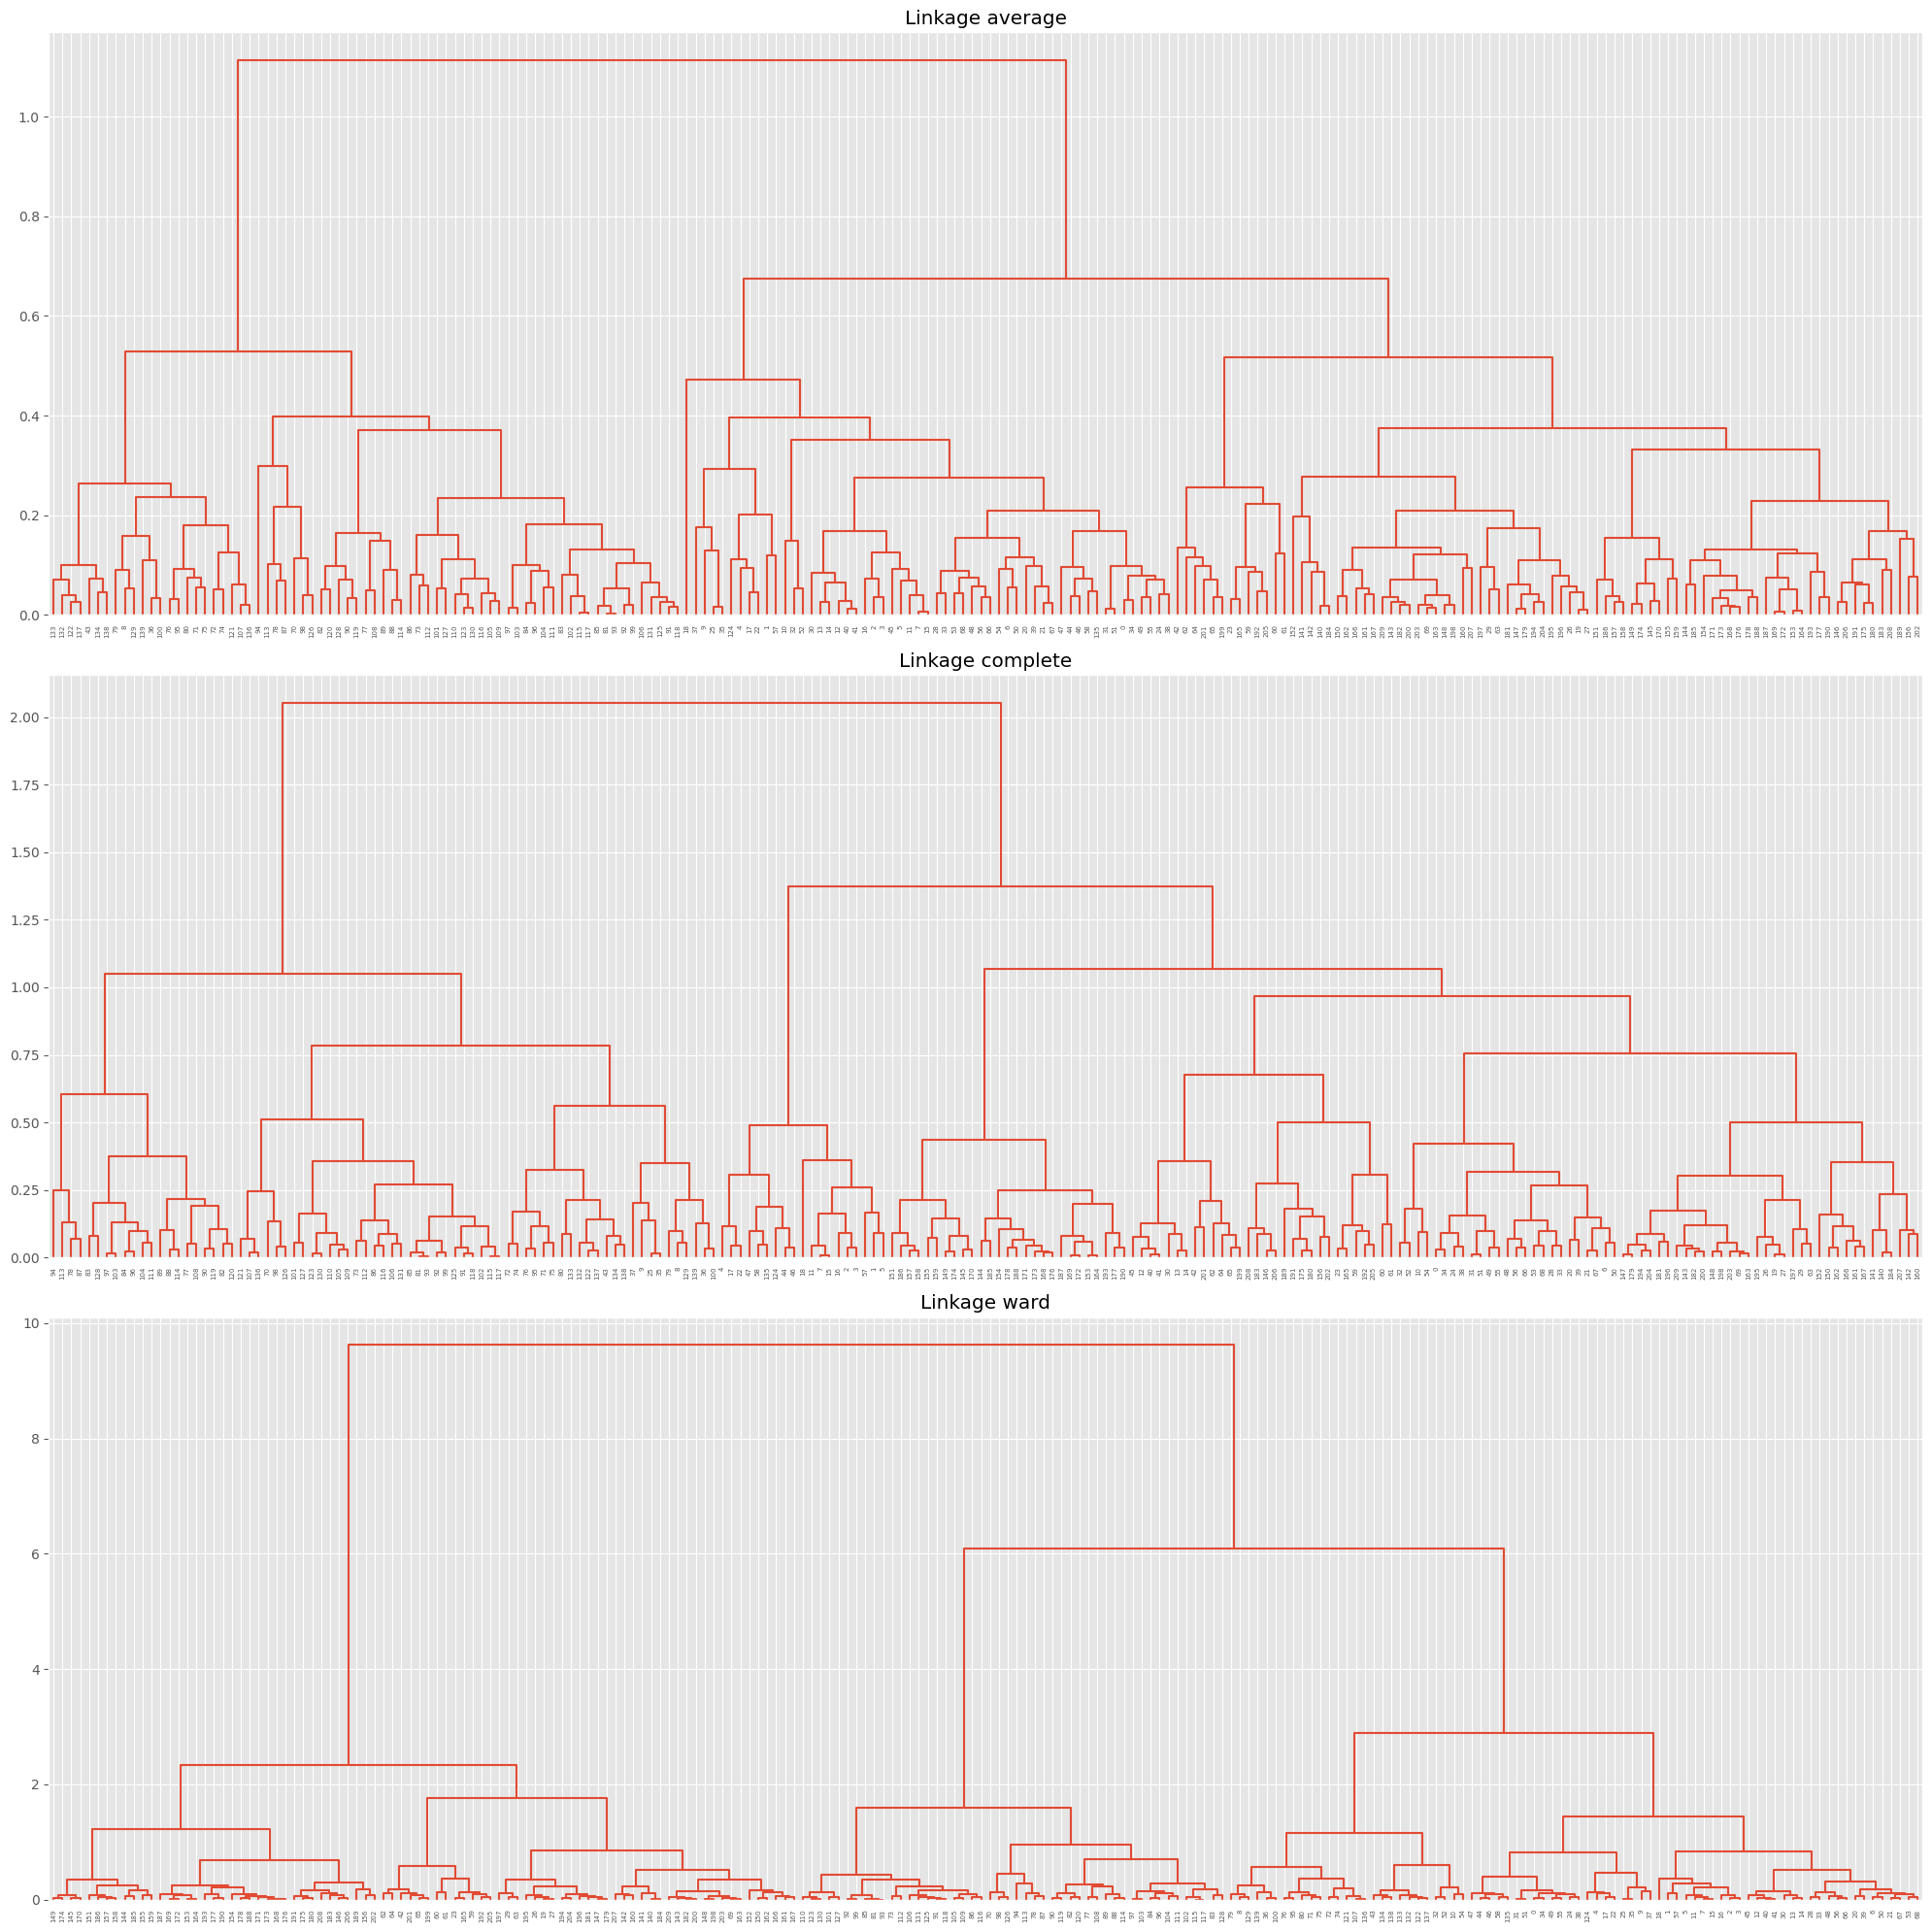

In [16]:
fig, axs = plt.subplots(3, 1, figsize=(20, 20))

plot_dendrogram(modelo_hclust_average, labels=range(len(X_final_pca)), color_threshold=0, ax=axs[0])
axs[0].set_title("Linkage average")

plot_dendrogram(modelo_hclust_complete, labels=range(len(X_final_pca)), color_threshold=0, ax=axs[1])
axs[1].set_title("Linkage complete")

plot_dendrogram(modelo_hclust_ward, labels=range(len(X_final_pca)), color_threshold=0, ax=axs[2])
axs[2].set_title("Linkage ward")

plt.tight_layout();

Among the three methods, the dendrogram generated with **`ward`** stands out for presenting a more balanced structure with more significant distance jumps at the upper levels of the tree, suggesting clearer and more natural divisions in the dataset.

In contrast, the dendrograms with `average` and `complete` show a more gradual progression, without such defined cuts, which may make it harder to visually identify an optimal number of clusters.

Even so, we will truncate the dendrograms to view them more clearly.


##### __Truncated Dendrograms for Easier Interpretation__

Since the complete dendrograms are very extensive and difficult to read, **truncated** versions are also generated using `truncate_mode='level'` and `p=5`, which show only the last levels of the hierarchical clustering.

This approach focuses on the main divisions and facilitates the visual identification of relevant groupings, such as choosing a reasonable number of clusters based on the cutting height.

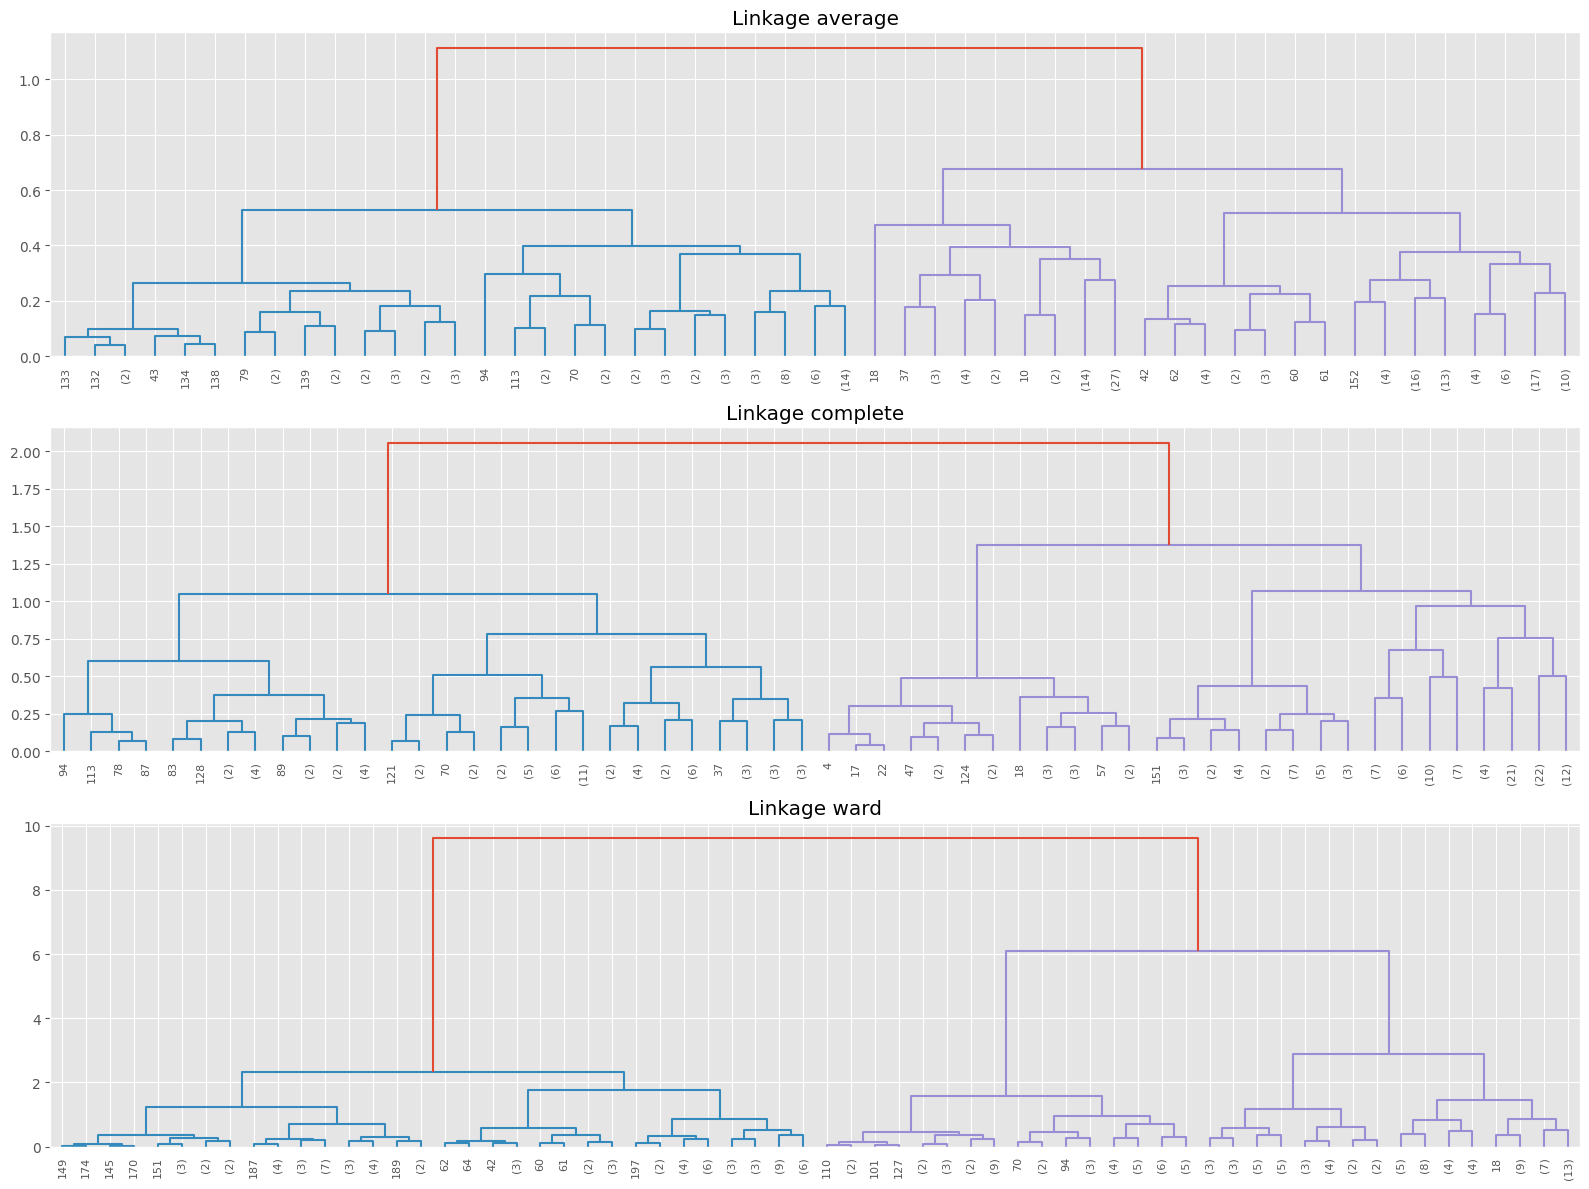

In [17]:
fig, axs = plt.subplots(3, 1, figsize=(16, 12))

plot_dendrogram(modelo_hclust_average, labels=range(len(X_final_pca)), 
                truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=8, ax=axs[0])
axs[0].set_title("Linkage average")

plot_dendrogram(modelo_hclust_complete, labels=range(len(X_final_pca)), 
                truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=8, ax=axs[1])
axs[1].set_title("Linkage complete")

plot_dendrogram(modelo_hclust_ward, labels=range(len(X_final_pca)), 
                truncate_mode='level', p=5, leaf_rotation=90, leaf_font_size=8, ax=axs[2])
axs[2].set_title("Linkage ward")

plt.tight_layout()
plt.show()


It is confirmed that the **`ward`** method presents clearer and more well-defined divisions, with a final merge occurring at a significantly higher height, indicating greater separation between groups.

In comparison, the **`average`** and **`complete`** methods show more gradual and less abrupt groupings, suggesting that the differences between consecutive groups are smoother and more progressive.

Overall, this visualization supports the choice of `ward` as the most effective method for capturing the hierarchical structure of the dataset.

##### __Visual Cut of the Dendrogram__

To determine the number of clusters, the dendrogram is visually cut at a certain height. For the Ward method, which has shown the best results, a cut is made at height 5.

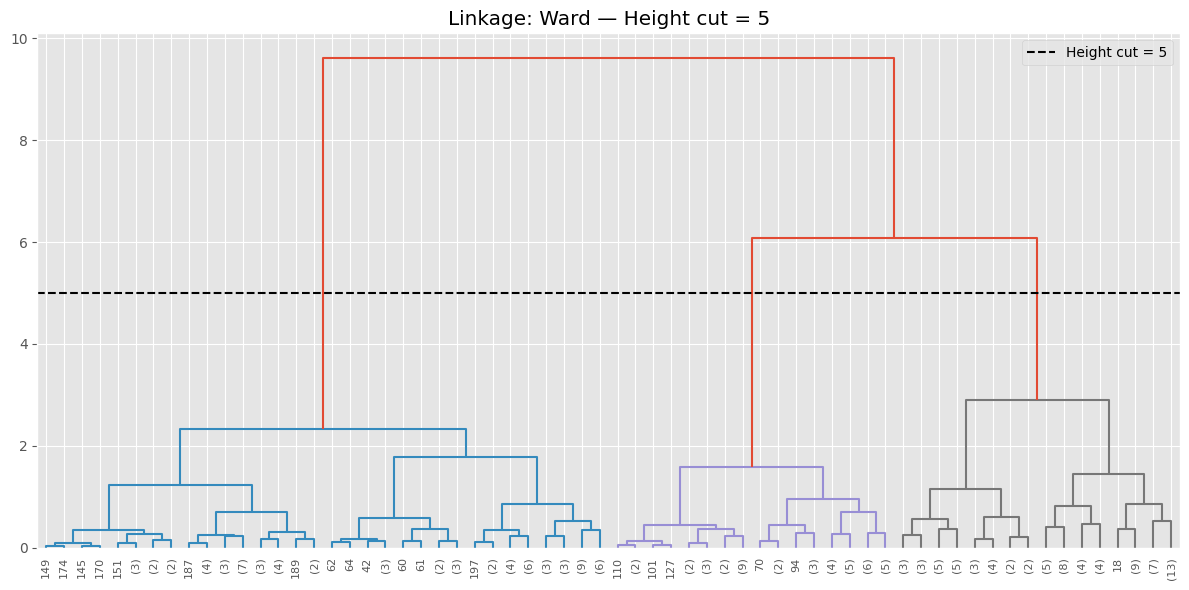

In [18]:
fig, ax = plt.subplots(1, 1, figsize=(12, 6))

altura_corte = 5

plot_dendrogram(
    modelo_hclust_ward,
    labels=range(len(X_final_pca)),
    truncate_mode='level',
    p=5,
    leaf_rotation=90,
    leaf_font_size=8,
    color_threshold=altura_corte,
    ax=ax
)

ax.set_title("Linkage: Ward — Height cut = 5")
ax.axhline(y=altura_corte, color='black', linestyle='--', label=f'Height cut = {altura_corte}')
ax.legend()
plt.tight_layout()
plt.show()


**3 main clusters** are clearly identified. This approach allows for intuitive segmentation of the data, based on the largest distance jumps between consecutive merges.

The cut at this height coincides with a point where a significant separation occurs in the hierarchical tree, suggesting that the natural structure of the data favors the existence of three large groups. This observation reinforces the results obtained with other methods such as K-Means and the silhouette analysis for k = 3.

##### __Silhouette Coefficient Method__

Apply the silhouette coefficient method to find the optimal number of clusters in hierarchical clustering (linkage='ward').

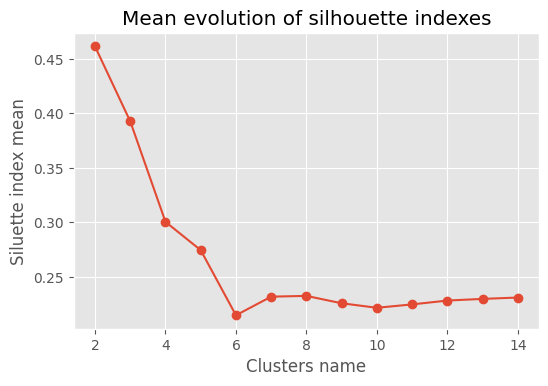

In [19]:
range_n_clusters = range(2, 15)
valores_medios_silhouette = []

for n_clusters in range_n_clusters:
    modelo = AgglomerativeClustering(
        linkage    = 'ward',
        n_clusters = n_clusters
    )

    cluster_labels = modelo.fit_predict(X_scaled)
    silhouette_avg = silhouette_score(X_scaled, cluster_labels)
    valores_medios_silhouette.append(silhouette_avg)

fig, ax = plt.subplots(1, 1, figsize=(6, 3.84))
ax.plot(range_n_clusters, valores_medios_silhouette, marker='o')
ax.set_title("Mean evolution of silhouette indexes")
ax.set_xlabel('Clusters name')
ax.set_ylabel('Siluette index mean');

The silhouette index analysis shows that the maximum value is reached for k = 2, with an average coefficient close to 0.46. From that point, the index decreases steadily, suggesting that dividing the dataset into more groups reduces cohesion within each cluster and separation between them.

Although this result suggests that k = 2 is optimal from a purely mathematical perspective, this value may be too simplistic regarding the actual structure of the dataset, which originally includes three seed classes. Therefore, k = 3 or k = 4 are also considered reasonable options, especially if a more informative segmentation aligned with prior knowledge is sought.


##### __Choice of Method and Number of Clusters__

After comparing different linkage methods and analyzing the results both visually and quantitatively, it is concluded that the best hierarchical clustering method for this dataset is the **ward** method, as it provides the most compact and well-separated clusters, supported by a good silhouette index.

The visual cut of the dendrogram at height 5 generates **3 clearly differentiated clusters**, which align with the most coherent results from the K-Means analysis and adequately reflect the structure of the dataset.

Therefore, we select the **ward** method and a number of clusters equal to 3 as the most suitable configuration to represent the natural groupings of seeds in this problem.


In [20]:
modelo_hclust_ward = AgglomerativeClustering(
    linkage  = 'ward',
    n_clusters = 3
)
modelo_hclust_ward.fit(X=X_scaled)

AgglomerativeClustering(n_clusters=3)

#### __3.3 DBSCAN Clustering__

#### DBSCAN (Density-Based Spatial Clustering of Applications with Noise)

DBSCAN is a clustering algorithm particularly effective for datasets with noise and varying densities. It relies on two parameters: 
- `eps` (the maximum distance between two samples for them to be considered as neighbors)
- `min_samples` (the minimum number of points required to form a dense region).

At first glance, it is evident that very few high-density regions can be observed, so we are unsure if this will be the best method.

##### __Classification and Model Training__

In [21]:
modelo_dbscan = DBSCAN(eps=0.3, min_samples=5, metric='euclidean')
modelo_dbscan.fit(X_final_pca)


DBSCAN(eps=0.3)

Draw the plot illustrating the clusters generated by the DBSCAN algorithm applied to the PCA-transformed dataset. Being able to identify clusters of varying shapes and sizes while marking points that do not belong to any cluster as outliers.

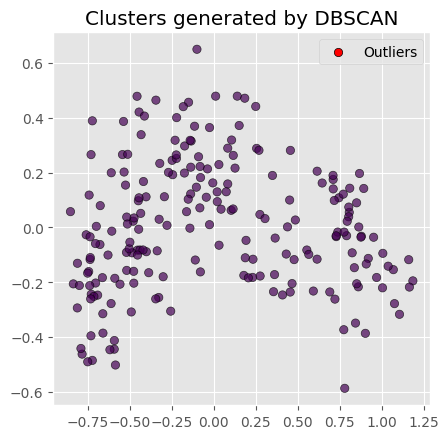

In [22]:
labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(4.5, 4.5))

ax.scatter(
    x=X_final_pca[:, 0],
    y=X_final_pca[:, 1],
    c=labels,
    cmap='viridis',
    edgecolor='black',
    alpha=0.7
)

ax.scatter(
    x=X_final_pca[labels == -1, 0],
    y=X_final_pca[labels == -1, 1],
    c='red',
    marker='o',
    edgecolor='black',
    label='Outliers'
)

ax.legend()
ax.set_title('Clusters generated by DBSCAN')
plt.grid(True)
plt.tight_layout()
plt.show()


With this graph, it can be observed that DBSCAN has not found clusters: practically all points are in dark color (i.e., in the same cluster) or likely marked as outliers.

This indicates that the parameters `eps` and/or `min_samples` are not yet well adjusted.

It is probably due to an excessively high `eps`, which causes all points to merge into a single cluster. To address this, we will create the k-distance graph to select an ideal eps.

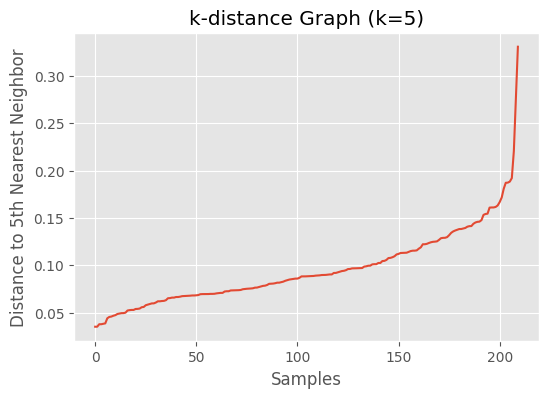

In [23]:
k = 5

# Fit the NearestNeighbors model
neighbors = NearestNeighbors(n_neighbors=k)
neighbors_fit = neighbors.fit(X_final_pca)

# Get distances to the k-th nearest neighbor
distances, indices = neighbors_fit.kneighbors(X_final_pca)

distances = np.sort(distances[:, k-1])

plt.figure(figsize=(6, 4))
plt.plot(distances)
plt.title('k-distance Graph (k=5)')
plt.xlabel('Samples')
plt.ylabel('Distance to 5th Nearest Neighbor')
plt.grid(True)
plt.show()


The k-distance graph suggests an approximate value of eps ≈ 0.18, as from that distance, the separations between points began to increase rapidly. However, when applying DBSCAN with `eps = 0.18`, it was observed that the algorithm tended to group most points into a single cluster.

For this reason, the value of eps was adjusted more strictly, testing lower values.

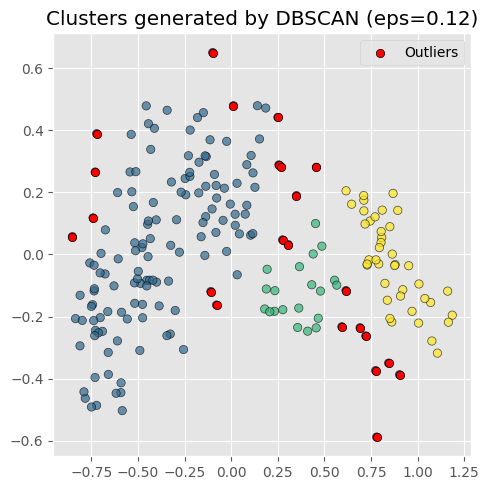

In [24]:
modelo_dbscan = DBSCAN(eps=0.12, min_samples=5, metric='euclidean')
modelo_dbscan.fit(X_final_pca)

labels = modelo_dbscan.labels_

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.scatter(
    X_final_pca[:, 0], 
    X_final_pca[:, 1], 
    c=labels, 
    cmap='viridis', 
    edgecolor='k', 
    alpha=0.7
)
ax.scatter(
    X_final_pca[labels == -1, 0], 
    X_final_pca[labels == -1, 1], 
    c='red', 
    marker='o', 
    edgecolor='black', 
    label='Outliers'
)
ax.legend()
ax.set_title('Clusters generated by DBSCAN (eps=0.12)')
plt.grid(True)
plt.tight_layout()
plt.show()


Finally, with `eps = 0.11` and `min_samples = 5`, a much more suitable segmentation was achieved: **3** compact and well-separated clusters were identified, along with a reasonable number of outliers.

In [25]:
n_clusters = len(set(labels)) - (1 if -1 in labels else 0)
n_noise = list(labels).count(-1)

print(f'Number of clusters found: {n_clusters}')
print(f'Number of outliers found: {n_noise}')

Number of clusters found: 3
Number of outliers found: 23


#### Conclusion of the Comparison of Methods

The graphical comparison of the three clustering methods shows consistent results:

- **K-Means** and **Hierarchical Clustering (ward)** produce very similar groupings, clearly identifying three large, well-separated groups in the PCA space.
- **DBSCAN** also detects similar structures but additionally identifies several **outliers** (marked in red), providing greater flexibility in handling atypical observations.
- Visually, **K-Means and Hierarchical Clustering** present a cleaner and more compact segmentation, while **DBSCAN** offers a more adaptive segmentation to noise and the local distribution of the data.

Together, the three methods confirm the existence of **three main groupings** in the seed dataset.


### __4. Analysis__ 

#### __4.1 Method that Best Captures the Cluster Structure__

The performance of the three clustering methods (K-Means, Hierarchical Clustering, and DBSCAN) is visually compared to determine which one most clearly and coherently identifies the natural structure of the data.


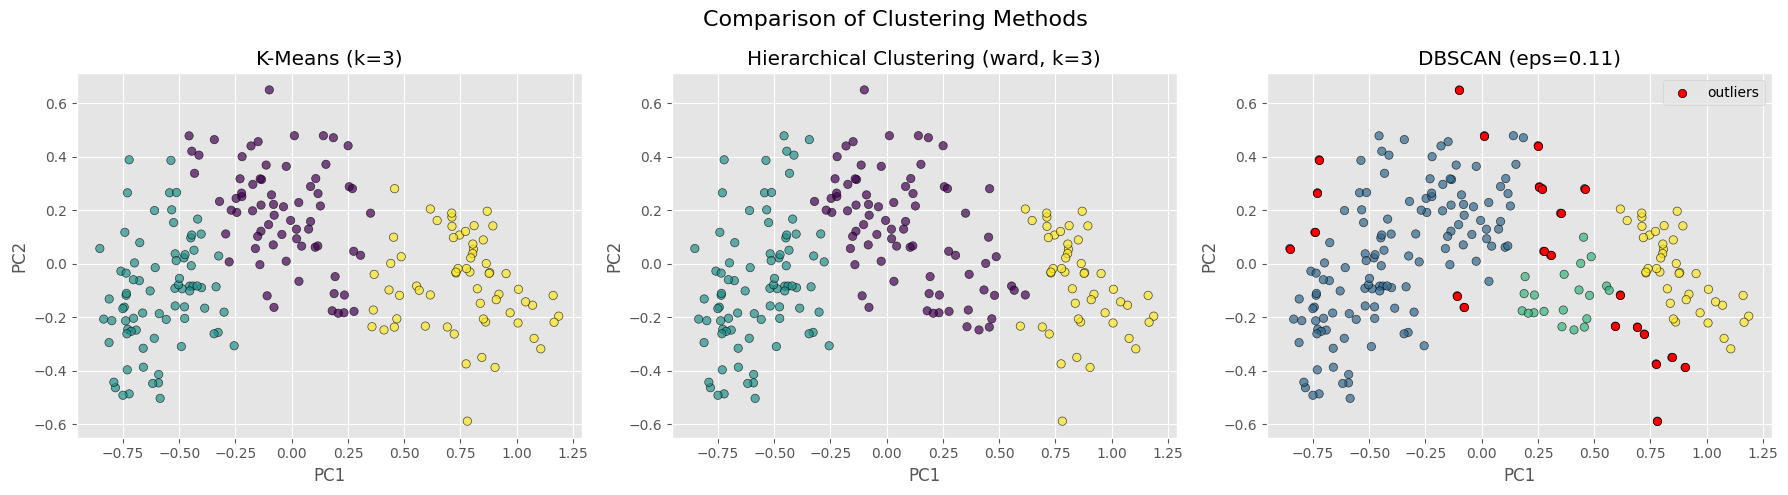

In [26]:

y_pred_kmeans = modelo_kmeans.predict(X_final_pca)

y_pred_agglo = modelo_hclust_ward.fit_predict(X_final_pca)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# K-Means
axes[0].scatter(X_final_pca[:, 0], X_final_pca[:, 1], c=y_pred_kmeans, cmap='viridis', edgecolor='k', alpha=0.7)
axes[0].set_title('K-Means (k=3)')
axes[0].set_xlabel('PC1')
axes[0].set_ylabel('PC2')
axes[0].grid(True)

# Clustering jerárquico (ward)
axes[1].scatter(X_final_pca[:, 0], X_final_pca[:, 1], c=y_pred_agglo, cmap='viridis', edgecolor='k', alpha=0.7)
axes[1].set_title('Hierarchical Clustering (ward, k=3)')
axes[1].set_xlabel('PC1')
axes[1].set_ylabel('PC2')
axes[1].grid(True)

# DBSCAN
axes[2].scatter(X_final_pca[:, 0], X_final_pca[:, 1], c=labels, cmap='viridis', edgecolor='k', alpha=0.7)
axes[2].scatter(
    X_final_pca[labels == -1, 0], 
    X_final_pca[labels == -1, 1], 
    c='red', 
    marker='o', 
    edgecolor='black',
    label='outliers'
)
axes[2].set_title('DBSCAN (eps=0.11)')
axes[2].set_xlabel('PC1')
axes[2].set_ylabel('PC2')
axes[2].legend()
axes[2].grid(True)

plt.suptitle('Comparison of Clustering Methods', fontsize=16)
plt.tight_layout()
plt.show()


After the visual comparison of K-Means, Hierarchical Clustering (ward), and DBSCAN, it is concluded that:

- **K-Means (k=3)** and **Hierarchical Clustering (ward, k=3)** are the methods that best capture the natural structure of the data, showing three compact, well-separated, and balanced-sized groups in the PCA space.
- **DBSCAN**, although it detects similar groupings, is more sensitive to parameter selection and generates a higher number of outliers, which can be useful in some contexts but is less desirable here, where a clear classification of all observations is expected.

Therefore, the method that best represents the clustering structure of this problem is Hierarchical Clustering (ward) or alternatively K-Means, both with 3 clusters.


#### __4.2 Relationship Between Clusters and Original Seed Classes__

The correspondence between the clusters generated by each method and the actual seed classes (`clase`) is analyzed using contingency tables to evaluate the degree of agreement between the unsupervised clustering and the real classification.


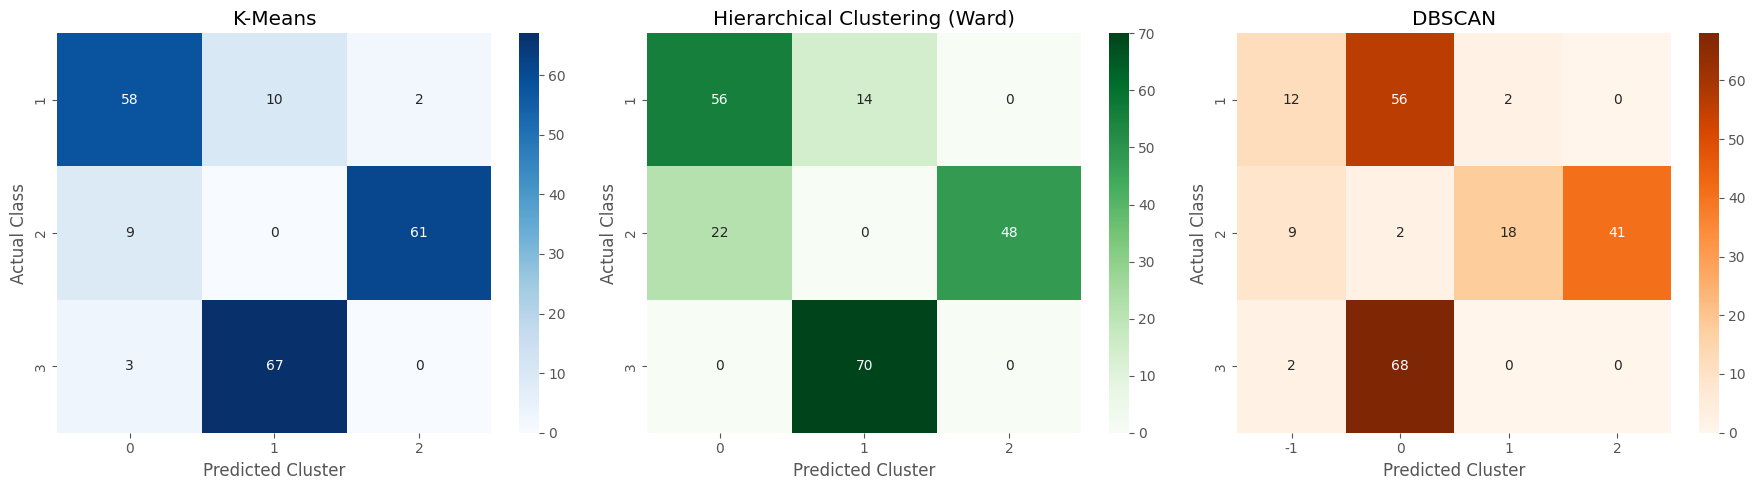

In [27]:
# Calculate contingency tables
contingency = pd.crosstab(y, y_pred_kmeans)
contingency_agglo = pd.crosstab(y, y_pred_agglo)
contingency_dbscan = pd.crosstab(y, labels)

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Confusion matrix for K-Means
sns.heatmap(contingency, annot=True, fmt='d', cmap='Blues', ax=axes[0])
axes[0].set_title('K-Means')
axes[0].set_xlabel('Predicted Cluster')
axes[0].set_ylabel('Actual Class')

# Confusion matrix for Hierarchical Clustering (Ward)
sns.heatmap(contingency_agglo, annot=True, fmt='d', cmap='Greens', ax=axes[1])
axes[1].set_title('Hierarchical Clustering (Ward)')
axes[1].set_xlabel('Predicted Cluster')
axes[1].set_ylabel('Actual Class')

# Confusion matrix for DBSCAN
sns.heatmap(contingency_dbscan, annot=True, fmt='d', cmap='Oranges', ax=axes[2])
axes[2].set_title('DBSCAN')
axes[2].set_xlabel('Predicted Cluster')
axes[2].set_ylabel('Actual Class')

plt.tight_layout()
plt.show()


##### The analysis of the contingency matrix between the actual seed classes and the obtained clusters shows that:

- There is a **clear correspondence** between the original classes and the formed clusters.
- **Class 1** is mostly grouped in **Cluster 0**.
- **Class 2** is concentrated in **Cluster 2**.
- **Class 3** is clearly associated with **Cluster 1**.

Although there are some misassigned observations, overall, the relationship between the identified clusters and the true classes is **very accurate** for an unsupervised clustering problem.


#### Comparing the contingency matrices obtained for the three clustering methods:

- **K-Means (k=3)** shows a **very clear correspondence** between the identified clusters and the actual classes. Each main class is mostly grouped into a single cluster, with few assignment errors.
  
- **Hierarchical Clustering (ward, k=3)** also identifies the main classes, although it shows greater dispersion of observations, especially in Class 2, where several observations are incorrectly grouped.

- **DBSCAN (eps=0.12)** manages to identify certain patterns but with more dispersion among classes and a significant number of observations marked as noise (-1), making classification less precise compared to K-Means or Ward. Additionally, some clusters are less defined in comparison.


| Method                         | Correspondence with actual classes | Handling of outliers | Ease of interpretation      |
|--------------------------------|------------------------------------|----------------------|-----------------------------|
| **K-Means (k=3)**              | Very high                         | Does not identify    | Very high                   | 
| **Hierarchical Clustering (Ward)** | High, though more dispersed       | Does not identify    | High (visualizable via dendrogram) |
| **DBSCAN (eps=0.12)**          | Moderate                          | Yes (detects outliers) | Moderate                   | 


We can conclude that:

- **K-Means** provides the most accurate and structured classification relative to the original classes.
- **Hierarchical Clustering (ward)** offers good results but is slightly more dispersed, especially for less compact classes.
- **DBSCAN**, while useful for detecting outliers and more flexible structures, is less effective here in faithfully reconstructing the original classes.

In conclusion, **K-Means with 3 clusters** is the method that best reflects the actual structure of the seed dataset, closely followed by **Hierarchical Clustering (ward)**.


#### __4.3 Interpretation of Clusters Using Boxplots__

The characteristics of the obtained clusters are interpreted through boxplots of the original variables, identifying which attributes differentiate each group and validating the consistency of the detected groupings.

As said, K-Means clustering is the selected method to analyze the clusters.

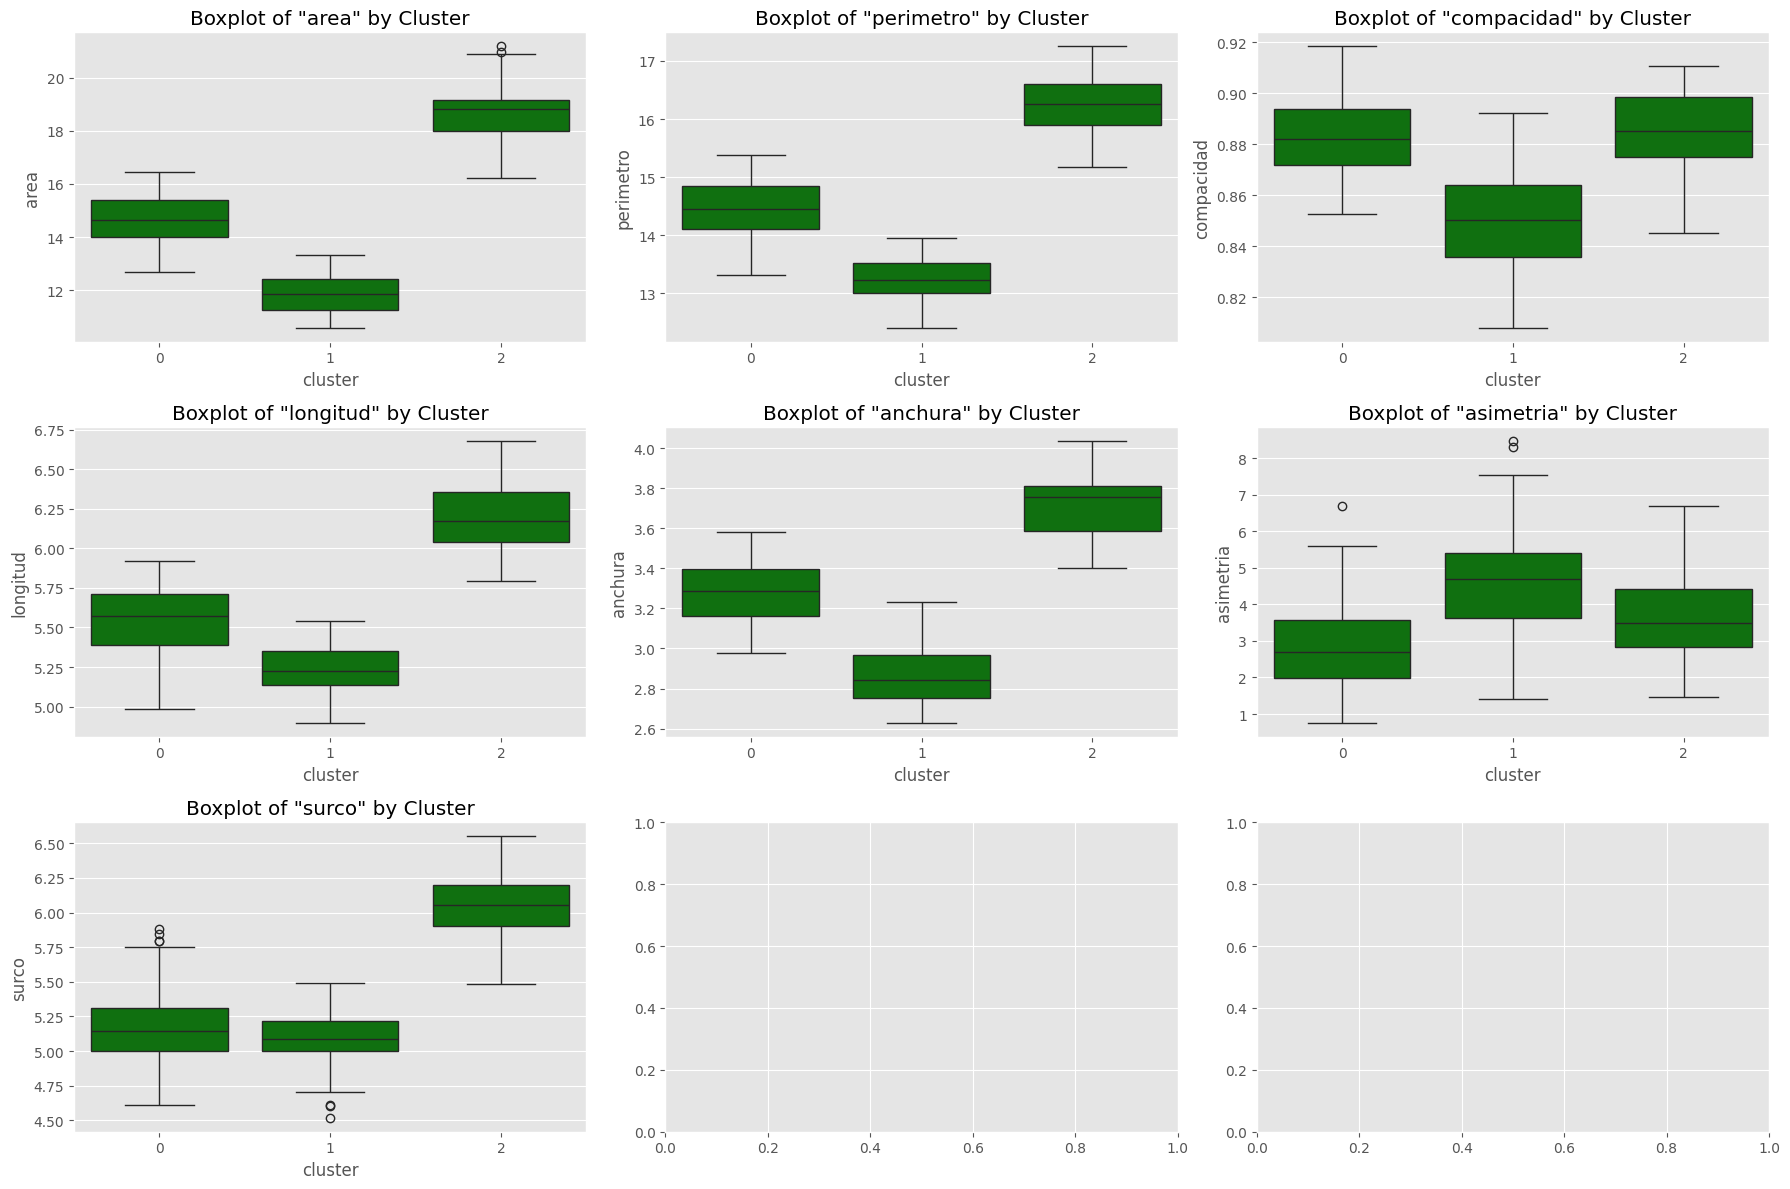

In [28]:
data_clusters = data.copy()
data_clusters['cluster'] = y_pred_kmeans 

variables = X.columns

fig, axes = plt.subplots(len(variables) // 3 + 1, 3, figsize=(18, 12))
axes = axes.flatten()

for i, var in enumerate(variables):
    sns.boxplot(x='cluster', y=var, data=data_clusters, ax=axes[i], color='green')
    axes[i].set_title(f'Boxplot of "{var}" by Cluster')

plt.tight_layout()
plt.show()


The boxplot analysis reveals clear differences between the obtained clusters:

- Variables such as **area**, **perimeter**, **length**, **width**, and **groove** show **very distinct separations** between clusters, demonstrating that these attributes are key to differentiating the seed groups.
- Specifically, **Cluster 2** groups seeds with higher values in all these variables, indicating it contains the largest seeds.
- **Cluster 1** gathers seeds with lower values in these variables, representing the smallest seeds, while **Cluster 0** shows intermediate values.
- The variables **compactness** and **asymmetry** also show some differences between clusters, although with **greater overlap** and **less discriminative power**.

In summary, the formed clusters reflect coherent physical groupings based on real characteristics, mainly in the size and shape of the seeds, validating the quality of the segmentation obtained through unsupervised clustering.


### __5. Final Conclusion of the Seed Clustering Analysis__

In this project, different clustering methods were applied and compared on the seed dataset:

- **K-Means (k=3)** and **Hierarchical Clustering (ward, k=3)** showed clear, compact, and well-separated groupings, adequately capturing the dataset's structure.
- **DBSCAN** identified similar groupings and detected outliers, although its performance strongly depended on the correct choice of `eps`.

The analysis of the relationship between the obtained clusters and the actual seed classes demonstrated a **strong correspondence**, especially with K-Means, where each class was mostly grouped into a specific cluster.

Finally, the interpretation through boxplots revealed significant differences in several original variables (area, perimeter, length, width, and groove), confirming that the identified clusters represent **physically distinct groups of seeds**.

Overall, the **K-Means method with 3 clusters** is the most recommended due to its simplicity, clarity of results, and alignment with the actual classes, although Hierarchical Clustering (ward) also provides equally solid results.


### __Personal Use of AI in the Practice__

During the completion of this practice, Artificial Intelligence was used as a support tool in various phases of the work. Specifically, it was employed to:

- Resolve conceptual doubts about the applied clustering methods (`K-Means`, `Hierarchical Clustering`, and `DBSCAN`).
- Obtain detailed explanations about the steps of the practice and the meaning of the results.
- Receive assistance in structuring the notebook in a clear, organized, and comprehensive manner.
- Draft and translate introductions, conclusions, and descriptions in appropriate technical language.
- Adjust and improve the interpretation of results, such as the analysis of boxplots and confusion matrices.
- Verify the rationale behind decisions made (e.g., the choice of `eps` in DBSCAN).
- Write the "Personal Use of AI in the Practice" section.

The use of this tool allowed for a more efficient completion of the practice, ensuring a better understanding of the concepts and a better presentation of the results, while maintaining personal responsibility in the analysis, interpretation, and final decision-making.
